# Segmentation

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, 'sources'))
sys.path.insert(0, sources_path)

import numpy 
import torch

#from specs import *
#from optosynth import Optosynth

device = torch.device("cpu")
dtype = torch.float32

## Paths

In [3]:
output_path = '/home/jupyter/external_disk/Optosynth_output'
output_prefix = 'test_data'

In [4]:
movie_dir = os.path.join(output_path, output_prefix)
file_list = next(iter(os.walk(movie_dir)))[2]

print(movie_dir)
print(file_list)

/home/jupyter/external_disk/Optosynth_output/test_data
['soma_coords_n2.npy', 'noisy_movie_tyx.npy', 'clean_movie_tyx.npy', 'masks_nyx.npy', 'background_tyx.npy', 'movie.html', 'clean_fluorescence_tyx.npy', 'neuron_mean_fluorescence_nt.npy']


## Load the clean movie and the mask

In [23]:
soma_coords_n2 = numpy.load(os.path.join(movie_dir,"soma_coords_n2.npy"))
#noisy_movie_tyx = numpy.load(os.path.join(movie_dir,"noisy_movie_tyx.npy"))
clean_movie_tyx = numpy.load(os.path.join(movie_dir,"clean_movie_tyx.npy"))
masks_nyx = numpy.load(os.path.join(movie_dir,"masks_nyx.npy"))
#background_tyx = numpy.load(os.path.join(movie_dir,"background_tyx.npy"))
#clean_fluorescence_tyx = numpy.load(os.path.join(movie_dir,"clean_fluorescence_tyx.npy"))
neuron_mean_fluorescence_nt = numpy.load(os.path.join(movie_dir,"neuron_mean_fluorescence_nt.npy"))

### Basic Inspection

In [25]:
print(type(clean_movie_tyx), clean_movie_tyx.shape, clean_movie_tyx.dtype)
print(type(masks_nyx), masks_nyx.shape, masks_nyx.dtype)
print(type(soma_coords_n2), soma_coords_n2.shape, soma_coords_n2.dtype)
print(type(neuron_mean_fluorescence_nt), neuron_mean_fluorescence_nt.shape, neuron_mean_fluorescence_nt.dtype)

<class 'numpy.ndarray'> (3000, 180, 512) float64
<class 'numpy.ndarray'> (50, 180, 512) bool
<class 'numpy.ndarray'> (50, 2) int64
<class 'numpy.ndarray'> (50, 3000) float64


### Foreground mask and Integer Mask

(180, 512) int64
(180, 512) bool


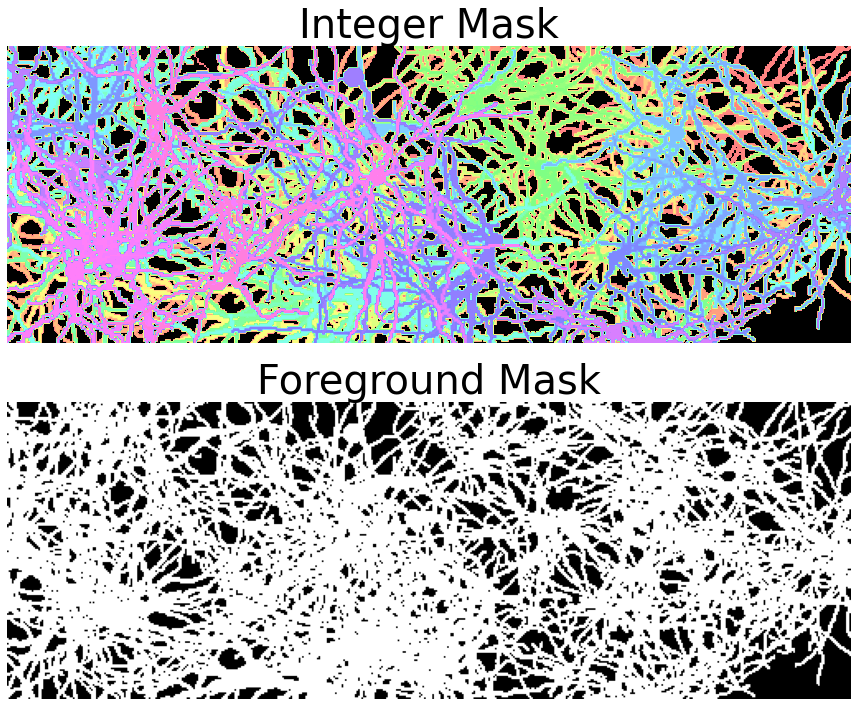

In [21]:
index = numpy.arange(masks_nyx.shape[0])+1  # 1,2,..., N
integer_mask = numpy.max(index[...,None,None] * masks_nyx, axis=0)
fg_mask = numpy.max(masks_nyx, axis=0)

print(integer_mask.shape, integer_mask.dtype)
print(fg_mask.shape, fg_mask.dtype)

colors = plt.cm.gist_rainbow(numpy.linspace(0, 1, numpy.max(integer_mask)))
colors[0, :] = [0, 0, 0, 1.]
colors[1:, 3] = 0.5
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', colors, numpy.max(integer_mask))
fig, ax = plt.subplots(nrows=2, figsize=(24,12))
ax[1].set_title("Foreground Mask", fontsize=40)
ax[1].imshow(fg_mask, cmap='gray')
ax[1].set_axis_off()

ax[0].set_title("Integer Mask", fontsize=40)
ax[0].imshow(integer_mask, cmap=custom_cmap)
ax[0].set_axis_off()

### Visualize Clean Movie

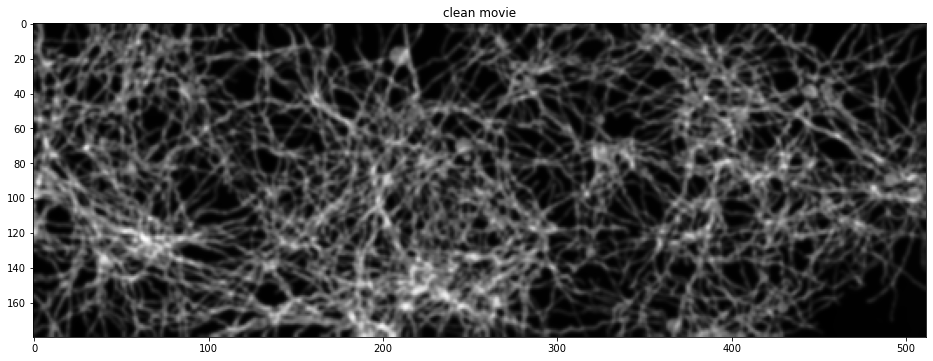

In [8]:
def show_movie(movie: numpy.array,
               interval: int = 10,
               figsize: tuple = (16,6)):
    assert isinstance(movie, numpy.ndarray)
    assert len(movie.shape) == 3
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("clean movie")
    im = ax.imshow(movie[0], cmap=plt.cm.Greys_r)    
    
    def animate(i):
        im.set_data(movie[i])
 
    anim = animation.FuncAnimation(fig, animate, frames=movie.shape[0], interval=interval)
    return HTML(anim.to_html5_video())

# make movie using every 10 frames and save to file
animated_movie = show_movie(clean_movie_tyx[::10])
#animated_movie = show_movie(clean_movie_tyx)

movie_file = os.path.join(movie_dir,'movie.html')
with open(movie_file, 'w') as f:
    f.write(animated_movie.data)

In [9]:
animated_movie

# Are all the neurons firing?

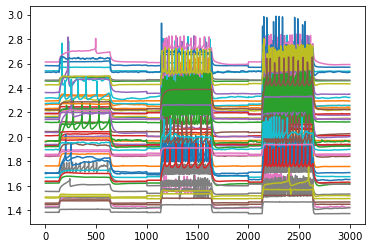

In [29]:
for i in range(neuron_mean_fluorescence_nt.shape[0]):
    plt.plot(neuron_mean_fluorescence_nt[i])

## Can I recover the fg mask from the movie?

In [10]:
def compute_moving_average(x: numpy.ndarray, 
                           axis: int, 
                           window_size: int):
    """ The window size should be an odd integer """
    assert (window_size +1) % 2 ==0
    N = x.shape[axis]
    pad_sequence = numpy.reshape([0,0]*len(x.shape), (len(x.shape), 2))
    pad_sequence[axis,:] = window_size
    x = numpy.pad(x, pad_width=pad_sequence, mode='edge')
    x = numpy.cumsum(x, axis=axis)
    r = (numpy.roll(x, shift=-window_size, axis=axis)-x)/window_size
    start = (window_size -1)//2
    return r[start:start+N]

In [11]:
clean_movie_tyx = clean_movie_tyx.astype(numpy.float)

In [12]:
mean_yx = numpy.mean(clean_movie_tyx, axis=0)
std_yx = numpy.std(clean_movie_tyx, axis=0, ddof=1)
max_diff_yx = numpy.max(clean_movie_tyx - mean_yx[None,...], axis=0)
ma_yx = compute_moving_average(clean_movie_tyx, axis=0, window_size=21)
max_diff_ma_yx = numpy.max(clean_movie_tyx - ma_yx, axis=0)

In [13]:
print(mean_yx.shape, mean_yx.dtype)
print(std_yx.shape, std_yx.dtype)
print(max_diff_yx.shape, max_diff_yx.dtype)
print(max_diff_ma_yx.shape, max_diff_ma_yx.dtype)

(180, 512) float64
(180, 512) float64
(180, 512) float64
(180, 512) float64


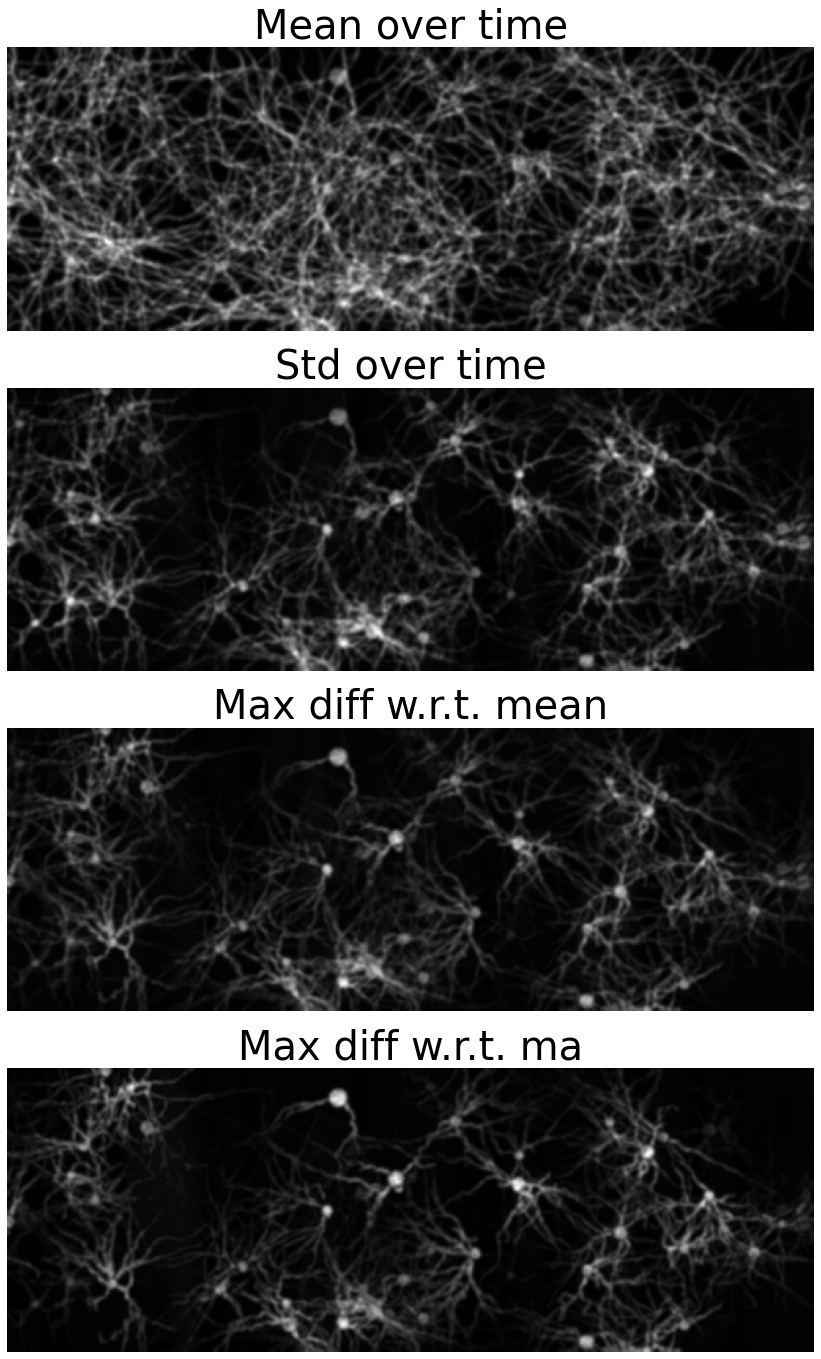

In [16]:
fig, ax = plt.subplots(nrows=4, figsize=(36,24))
ax[0].set_title("Mean over time", fontsize=40)
ax[0].imshow(mean_yx , cmap='gray')
ax[0].set_axis_off()
ax[1].set_title("Std over time", fontsize=40)
ax[1].imshow(std_yx, cmap='gray')
ax[1].set_axis_off()
ax[2].set_title("Max diff w.r.t. mean", fontsize=40)
ax[2].imshow(max_diff_yx, cmap='gray')
ax[2].set_axis_off()
ax[3].set_title("Max diff w.r.t. ma", fontsize=40)
ax[3].imshow(max_diff_ma_yx, cmap='gray')
ax[3].set_axis_off()

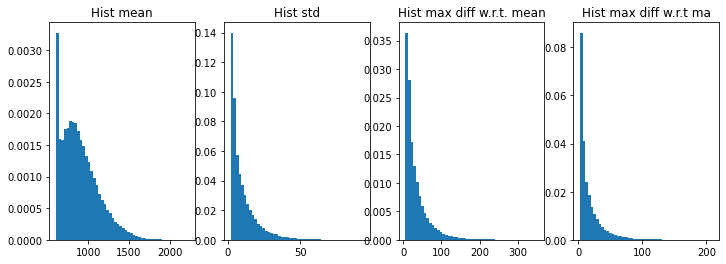

In [17]:
fontsize = 12
nbins = 50
fig, ax = plt.subplots(ncols=4, figsize=(12,4))
ax[0].set_title("Hist mean", fontsize=fontsize)
ax[0].hist(mean_yx.flatten(), density=True, bins=nbins)
ax[1].set_title("Hist std", fontsize=fontsize)
ax[1].hist(std_yx.flatten(), density=True, bins=nbins)
ax[2].set_title("Hist max diff w.r.t. mean", fontsize=fontsize)
ax[2].hist(max_diff_yx.flatten(), density=True, bins=nbins)
ax[3].set_title("Hist max diff w.r.t ma", fontsize=fontsize)
_ = ax[3].hist(max_diff_ma_yx.flatten(), density=True, bins=nbins)

959.2219776877675 17.928206348662485 60.259598388204324 35.87973443946525


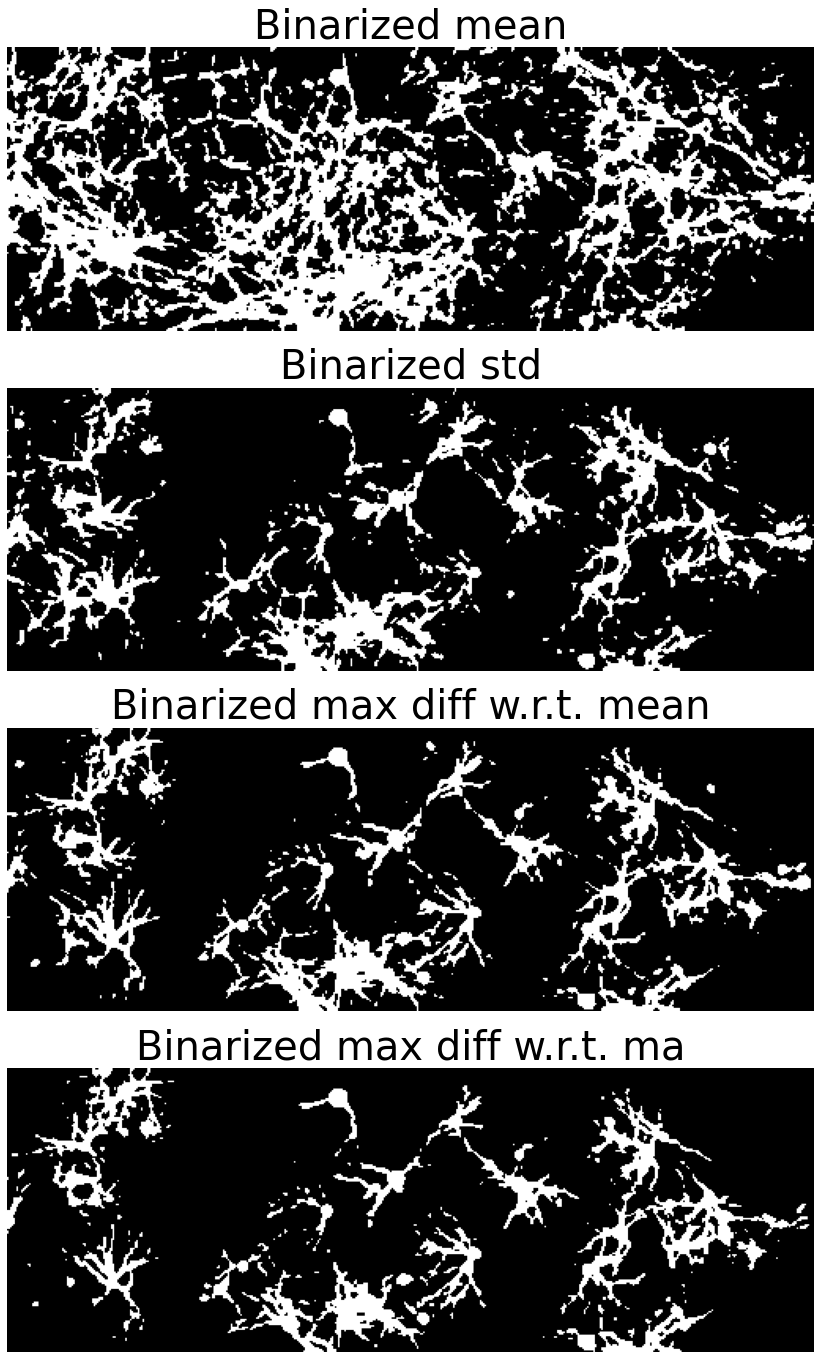

In [20]:
import skimage.filters

mean_th = skimage.filters.threshold_otsu(mean_yx)
std_th = skimage.filters.threshold_otsu(std_yx)
max_diff_mean_th = skimage.filters.threshold_otsu(max_diff_yx)
max_diff_ma_th = skimage.filters.threshold_otsu(max_diff_ma_yx)
print(mean_th, std_th, max_diff_mean_th, max_diff_ma_th)
mean_binarized = (mean_yx > mean_th)
std_binarized = (std_yx > std_th)
max_diff_mean_binarized = (max_diff_yx > max_diff_mean_th)
max_diff_ma_binarized = (max_diff_ma_yx > max_diff_ma_th)

fig, ax = plt.subplots(nrows=4, figsize=(36,24))
ax[0].set_title("Binarized mean", fontsize=40)
ax[0].imshow(mean_binarized, cmap='gray')
ax[0].set_axis_off()
ax[1].set_title("Binarized std", fontsize=40)
ax[1].imshow(std_binarized, cmap='gray')
ax[1].set_axis_off()
ax[2].set_title("Binarized max diff w.r.t. mean", fontsize=40)
ax[2].imshow(max_diff_mean_binarized, cmap='gray')
ax[2].set_axis_off()
ax[3].set_title("Binarized max diff w.r.t. ma", fontsize=40)
ax[3].imshow(max_diff_ma_binarized, cmap='gray')
ax[3].set_axis_off()

# FROM HERE

check that:
1. you can recover the fg mask 
2. you can segment fg mask into object by using graph approach